### 다중공선성
- 독립변수들이 서로 독립이 아니라 상호상관관계가 강한 경우에 발생한다.
- 독립변수의 공분산 행렬이 full rank 이어야 한다는 조건을 침해한다.


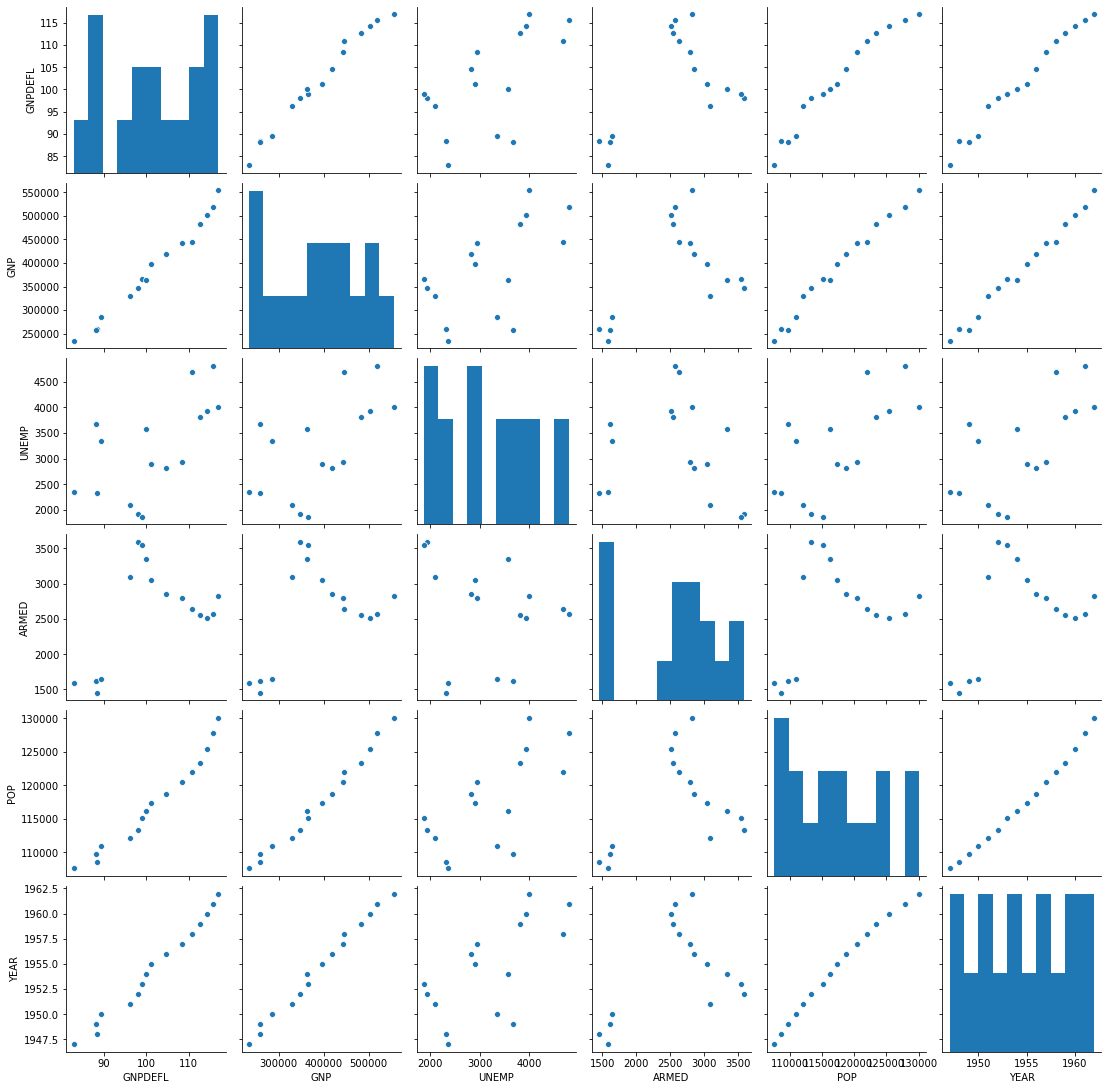

In [5]:
from statsmodels.datasets.longley import load_pandas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dfy = load_pandas().endog
dfX = load_pandas().exog
df = pd.concat([dfy, dfX], axis=1)
sns.pairplot(dfX)
plt.show() # 독립변수간의 상관관계가 강하다.

In [6]:
dfX.corr()

,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
GNPDEFL,1.000000,0.991589,0.620633,0.464744,0.979163,0.991149
GNP,0.991589,1.000000,0.604261,0.446437,0.991090,0.995273
UNEMP,0.620633,0.604261,1.000000,-0.177421,0.686552,0.668257
ARMED,0.464744,0.446437,-0.177421,1.000000,0.364416,0.417245
POP,0.979163,0.991090,0.686552,0.364416,1.000000,0.993953
YEAR,0.991149,0.995273,0.668257,0.417245,0.993953,1.000000


In [8]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

def get_model1(seed):
    df_train, df_test = train_test_split(df, test_size=0.5, random_state=seed)
    model = sm.OLS.from_formula("TOTEMP ~ GNPDEFL + POP + GNP + YEAR + ARMED + UNEMP", data=df_train)
    return df_train, df_test, model.fit()


df_train, df_test, result1 = get_model1(3)
print(result1.summary()) # 조건수가 높고 결정계수가 1이다

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     437.5
Date:                Sun, 04 Jul 2021   Prob (F-statistic):             0.0366
Time:                        20:04:49   Log-Likelihood:                -44.199
No. Observations:                   8   AIC:                             102.4
Df Residuals:                       1   BIC:                             103.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.235e+07   2.97e+06     -4.165      0.1

/Users/johyeogsang/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [10]:
def calc_r2(df_test, result):
    target = df.loc[df_test.index].TOTEMP
    predict_test = result.predict(df_test)
    RSS = ((predict_test - target)**2).sum()
    TSS = ((target - target.mean())**2).sum()
    return 1 - RSS / TSS


test1 = []
for i in range(10):
    df_train, df_test, result = get_model1(i)
    test1.append(calc_r2(df_test, result))

test1 # 교차검증 결과 다중공선성이 있음을 알 수 있다.

[0.9815050656844267,
 0.973849754306501,
 0.9879366370011322,
 0.7588861967876803,
 0.9807206089304095,
 0.8937889315063796,
 0.8798563810571698,
 0.931466577896602,
 0.8608525682213877,
 0.9677198735128874]

### VIF
- 변수 x1, x2, x3 ... 서로 값을 예측한 결정계수 값이 높을 수록, 지워야되는 변수다.
- VIF = (시그마^2 / (n-1)var(x)) * (1 / 1 - R^2) # 결정계수가 값이 크면 VIF값은 커진다 따라서 VIF가 큰 값을 제거한다.

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif # GNPDEFL, GNP, POP을 제거 해야겠다.

,VIF Factor,features
0,12425.514335,GNPDEFL
1,10290.435437,GNP
2,136.224354,UNEMP
3,39.983386,ARMED
4,101193.161993,POP
5,84709.950443,YEAR


In [14]:
def get_model2(seed):
    df_train, df_test = train_test_split(df, test_size=0.5, random_state=seed)
    model = sm.OLS.from_formula("TOTEMP ~ scale(GNP) + scale(ARMED) + scale(UNEMP)", data=df_train)
    return df_train, df_test, model.fit()


df_train, df_test, result2 = get_model2(3)
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     118.6
Date:                Sun, 04 Jul 2021   Prob (F-statistic):           0.000231
Time:                        20:10:38   Log-Likelihood:                -57.695
No. Observations:                   8   AIC:                             123.4
Df Residuals:                       4   BIC:                             123.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.538e+04    163.988    398.686   

/Users/johyeogsang/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [15]:
test2 = []
for i in range(10):
    df_train, df_test, result = get_model2(i)
    test2.append(calc_r2(df_test, result))

test2 # 과적합이 발생하지 않는다.

[0.9763608388904904,
 0.9841984331185691,
 0.9687069366140136,
 0.9397304053201788,
 0.9773357061188463,
 0.9561262155732307,
 0.9803852496698645,
 0.9917361722470804,
 0.9837134067639469,
 0.9789512977093212]